In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
#Extracting data

df = pd.read_csv(
    Path("nsdq_top_10.csv"),
    index_col="Date",
    infer_datetime_format=True,
    parse_dates=True,
)
df.head()


df = df.rename(columns={'^NDX' : 'NASDAQ_100'})

df_top_10_returns = df.pct_change()
df_top_10_returns.dropna(inplace=True)

df_ndx = df_top_10_returns["NASDAQ_100"].to_frame()

df_top_10_returns.drop(columns=["NASDAQ_100"], inplace=True)

df_ndx

,NASDAQ_100
Date,
2020-01-03,-0.008827
2020-01-06,0.006211
2020-01-07,-0.000234
2020-01-08,0.007452
2020-01-09,0.008669
...,...
2021-11-24,0.003746
2021-11-26,-0.020909
2021-11-29,0.023316


In [3]:
#Calculating cummulative returns for nasdaq

df_ndx_cummulative = (1+df_ndx).cumprod()

In [4]:
#Assigning weights and creating a portfolio of 10 companies

weights = np.array([0.21, 0.038, 0.134, 0.057, 0.072, 0.066, 0.192, 0.032, 0.095, 0.104])

mean_daily_returns = df_top_10_returns.mean()
port_return = np.sum(mean_daily_returns*weights)
print(port_return)

df_top_10_returns['Portfolio'] = df_top_10_returns.dot(weights)



0.0023837776304791634


<AxesSubplot:xlabel='Date'>

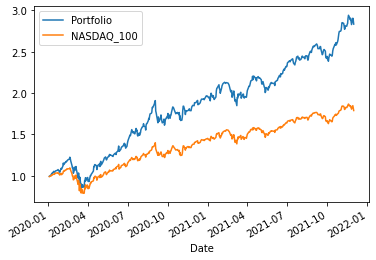

In [5]:
#Converting portfolio to cummulative returns

df_cummulative = (1+df_top_10_returns).cumprod()
df_cummulative.head()

df2 = df_cummulative["Portfolio"].to_frame()
df2 = df2.join(df_ndx_cummulative, how="inner")
df2.plot()

In [82]:
df2.corr()

,Portfolio,NASDAQ_100
Portfolio,1.000000,0.994686
NASDAQ_100,0.994686,1.000000


In [6]:
# This function accepts the column number for the features (X) and the target (y)
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [7]:
# Predicting Closing Prices using a window of previous closing prices

window_size = 30

#Setting Features and target columns
feature_column = 0
target_column = 1
X, y = window_data(df2, window_size, feature_column, target_column)

In [8]:
#Splitting data into train test 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [9]:
#Scaling the data

scaler = MinMaxScaler()
scaler.fit(X_train)

# Scaling the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fitting the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scaling the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [10]:
# Reshaping the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [54]:
# Building the LSTM model. 
# Defining the LSTM model.

model = Sequential()

dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=8,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=4, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=2))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [55]:
#Model Summary 

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 8)             320       
                                                                 
 dropout_6 (Dropout)         (None, 30, 8)             0         
                                                                 
 lstm_7 (LSTM)               (None, 30, 4)             208       
                                                                 
 dropout_7 (Dropout)         (None, 30, 4)             0         
                                                                 
 lstm_8 (LSTM)               (None, 2)                 56        
                                                                 
 dropout_8 (Dropout)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [64]:
# Compiling the model

model.compile(optimizer="adam", loss="mean_squared_error")

In [75]:
#Training the model

model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=1, verbose=1)

Epoch 1/50
339/339 [==============================] - 8s 25ms/step - loss: 0.0114
Epoch 2/50
339/339 [==============================] - 8s 22ms/step - loss: 0.0091
Epoch 3/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0100
Epoch 4/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0097
Epoch 5/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0090
Epoch 6/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0096
Epoch 7/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0083
Epoch 8/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0075
Epoch 9/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0108
Epoch 10/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0078
Epoch 11/50
339/339 [==============================] - 8s 23ms/step - loss: 0.0105
Epoch 12/50
339/339 [==============================] - 8s 24ms/step - loss: 0.0095
Epoch 13/50
3

Epoch 1/10
15/15 [==============================] - 1s 47ms/step - loss: 0.0548 - val_loss: 0.0724
Epoch 2/10
15/15 [==============================] - 1s 44ms/step - loss: 0.0474 - val_loss: 0.0737
Epoch 3/10
15/15 [==============================] - 1s 42ms/step - loss: 0.0455 - val_loss: 0.0749
Epoch 4/10
15/15 [==============================] - 1s 45ms/step - loss: 0.0476 - val_loss: 0.0752
Epoch 5/10
15/15 [==============================] - 1s 43ms/step - loss: 0.0508 - val_loss: 0.0815
Epoch 6/10
15/15 [==============================] - 1s 45ms/step - loss: 0.0378 - val_loss: 0.0752
Epoch 7/10
15/15 [==============================] - 1s 46ms/step - loss: 0.0530 - val_loss: 0.0826
Epoch 8/10
15/15 [==============================] - 1s 43ms/step - loss: 0.0442 - val_loss: 0.0777
Epoch 9/10
15/15 [==============================] - 1s 44ms/step - loss: 0.0430 - val_loss: 0.0867
Epoch 10/10
15/15 [==============================] - 1s 44ms/step - loss: 0.0361 - val_loss: 0.0852


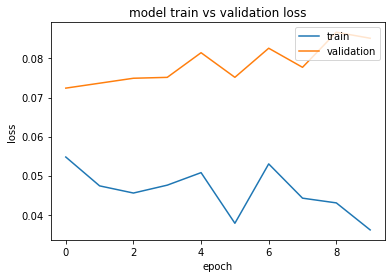

In [73]:
#Visualizing model training vs validation loss

history = model.fit(X, y, epochs=10, validation_data=(X_train, y_train))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [46]:
# Evaluating the model
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 12ms/step - loss: 0.0106


0.010618694126605988

In [76]:
# Making predictions
predicted = model.predict(X_test)

In [78]:
# Recovering the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [79]:
# Retrieving original Prices and converting into data frame

ndx = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df2.index[-len(real_prices): ]) 

ndx

,Real,Predicted
Date,,
2021-06-23,0.976603,1.072404
2021-06-24,1.725929,1.643767
2021-06-25,1.321181,1.320034
2021-06-28,1.672933,1.623582
2021-06-29,1.069070,1.123270
...,...,...
2021-11-24,1.452656,1.435995
2021-11-26,1.141803,1.172728
2021-11-29,1.284800,1.271070


<AxesSubplot:xlabel='Date'>

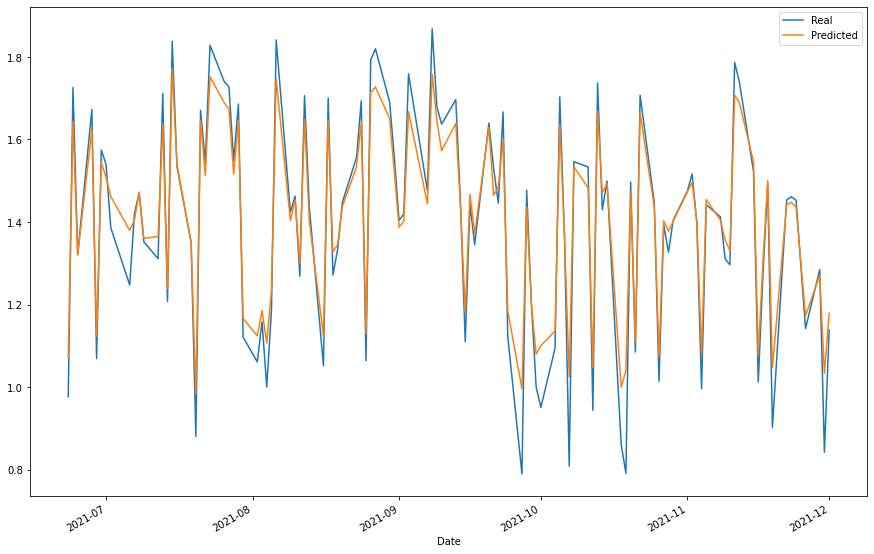

In [80]:
#Visualizing the predictions.

ndx.plot(figsize=(15,10))